# HW 3 - Synonym Detection In Spark
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the last homework assignment you performed Naive Bayes to classify documents as 'ham' or 'spam.' In doing so, we relied on the implicit assumption that the list of words in a document can tell us something about the nature of that document's content. We'll rely on a similar intuition this week: the idea that, if we analyze a large enough corpus of text, the list of words that appear in small window before or after a vocabulary term can tell us something about that term's meaning. This is similar to the intuition behind the word2vec algorithm.

This will be your first assignment working in Spark. You'll perform Synonym Detection by repurposing an algorithm commonly used in Natural Language Processing to perform document similarity analysis. In doing so you'll also become familiar with important datatypes for efficiently processing sparse vectors and a number of set similarity metrics (e.g. Cosine, Jaccard, Dice). By the end of this homework you should be able to:  
* ... __define__ the terms `one-hot encoding`, `co-occurrance matrix`, `stripe`, `inverted index`, `postings`, and `basis vocabulary` in the context of both synonym detection and document similarity analysis.
* ... __explain__ the reasoning behind using a word stripe to compare word meanings.
* ... __identify__ what makes set-similarity calculations computationally challenging.
* ... __implement__ stateless algorithms in Spark to build stripes, inverted index and compute similarity metrics.
* ... __identify__ when it makes sense to take a stripe approach and when to use pairs
* ... __apply__ appropriate metrics to assess the performance of your synonym detection algorithm. 

__RECOMMENDED READING FOR HW3__:	
Your reading assignment for weeks 4 and 5 were fairly heavy and you may have glossed over the papers on dimension independent similarity metrics by [Zadeh et al](http://stanford.edu/~rezab/papers/disco.pdf) and pairwise document similarity by [Elsayed et al](https://terpconnect.umd.edu/~oard/pdf/acl08elsayed2.pdf). If you haven't already, this would be a good time to review those readings, especially when it comes to the similarity formulas -- they are directly relevant to this assignment.

DITP Chapter 4 - Inverted Indexing for Text Retrieval. While this text is specific to Hadoop, the Map/Reduce concepts still apply.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
import re
import ast
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session (RUN THIS CELL AS IS)
from pyspark.sql import SparkSession
app_name = "hw3_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

21/10/01 18:35:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# Spark configuration Information (RUN THIS CELL AS IS)
sc.getConf().getAll()

[('spark.driver.port', '42391'),
 ('spark.app.id', 'local-1633113338537'),
 ('spark.app.name', 'hw3_notebook'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.driver.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.sql.warehouse.dir',
  'file:/home/erinwerner1997_gmail_com/Assignments/HW3/docker/student/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.startTime', '1633113336564'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.extraJavaOptions',
  '-Dio.netty.tryReflectionSetAccessible=true'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
# get Spark Session info (RUN THIS CELL AS IS)
spark

In [6]:
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()
    print("Unpersisted {} rdd".format(id))

# Question 1: Spark Basics.
In your readings and live session demos for weeks 4 and 5 you got a crash course in working with Spark. We also talked about how Spark RDDs fit into the broader picture of distributed algorithm design. The questions below cover key points from these discussions. Answer each one very briefly - 2 to 3 sentences.

### Q1 Tasks:

* __a) short response:__ What is Spark? How  does it relate to Hadoop MapReduce?

* __b) short response:__ In what ways does Spark follow the principles of statelessness (a.k.a. functional programming)? List at least one way in which it allows the programmer to depart from this principle. 

* __c) short response:__ In the context of Spark what is a 'DAG' and how does it relate to the difference between an 'action' and a 'transformation'? Why is it useful to pay attention to the DAG that underlies your Spark implementation?

### Q1 Student Answers:

> __a)__ 

Spark is an open-source, distributed processing system used for big data workloads that utilizes in-memory caching and optimized query execution for fast queries against data of any size. Spark is closely related to MapReduce in functionality, with the primary difference being that Spark processes and retains data in memory for subsequent steps, whereas MapReduce processes data on disk. As a result, for smaller workloads, Spark's data processing speeds are much faster than MapReduce.

> __b)__ 

Spark follows the principles of statelessness (functional programming), but also allows the programmer to depart from these princlies. This is because Spark Streaming uses the concept of DStreams, which are basically micro batches of data that are RDDs. DStream transformations can be both stateless, which follows the principles of functional programming, and stateful, which deviates from those same principles. While some of Spark's RDD operators are stateless, such as map or filter, the programmer can also implement stateful features as they may also ask Spark to persist an RDD in memory, allowing it to be reused efficiently across parallel operations.

> __c)__ 

A DAG is a directed acyclic graph. Spark keeps track of a DAG that contains the list of transformations needed to recreate each RDD and only actually performs those transformations when an action is called. It is useful to pay attention to the DAGs as they are, essentially, an execution plan that allows transformations to be evaluated lazily when triggered by an action and more complex DAGs may need to reuse the contents of an RDD for multiple downstream operations. This information is especially useful when checking the results of our Spark streaming jobs.


# Question 2: Similarity Metrics
As mentioned in the introduction to this assignment, an intuitive way to compare the meaning of two documents is to compare the list of words they contain. Given a vocabulary \\(V\\) (feature set) we would represent each document as a vector of `1`-s and `0`-s based on whether or not it contains each word in \\(V\\). These "one-hot encoded" vector representations allow us to use math to identify similar documents. However like many NLP tasks the high-dimensionality of the feature space is a challenge... especially when we start to scale up the size and number of documents we want to compare.

In this question we'll look at a toy example of document similarity analysis. Consider these 3 'documents': 
```
docA	the flight of a bumblebee
docB	the length of a flight
docC	buzzing bumblebee flight
```
These documents have a total of \\(7\\) unique words: 
>`a, bumblebee, buzzing, flight, length, of, the`.     

Given this vocabulary, the documents' vector representations are (note that one-hot encoded entries follow the order of the vocab list above):

```
docA	[1,1,0,1,0,1,1]
docB	[1,0,0,1,1,1,1]
docC	[0,1,1,1,0,0,0]
```  

### Q2 Tasks:

* __a) short response:__ The cosine similarity between two vectors is $$\frac{A\cdot B}{\|A\|\|B\|}$$. Explain what the the numerator and denominator of this calculation would represent in terms of word counts in documents A and B. 

* __b) short response:__ Explain how the Jaccard, Overlap and Dice metrics are similar/different to the calculation for cosine similarity. When would these metrics lead to different similarity rankings for a set of documents? HINT: consider documents of very different lengths. It may be helpful to generate some small examples.

* __c) short response:__ Calculate the cosine similarity for each pair of documents in our toy corpus. Please use markdown and \\(\LaTeX\\) to show your calcuations.  

* __d) short response:__ According to your calculations in `part c` which pair of documents are most similar in meaning? __BONUS__: Does this match your expecatation from reading the documents? If not, speculate about why we might have gotten this result.

* __e) short response:__ In NLP common words like '`the`', '`of`', and '`a`' increase our feature space without adding a lot of signal about _semantic meaning_. Repeat your analysis from `part c` but this time ignore these three words in your calculations [__`TIP:`__ _to 'remove' stopwords just ignore the vector entries in columns corresponding to the words you wish to disregard_]. How do your results change?

### Q2 Student Answers:

> __a)__ 

With cosine similarity, we’re considering vectors in spaces. The cosine similarity ranges from -1 to 1, and gets larger when the angle in question is smaller. In the numerator, the dot product of two vectors describes the extent that the vectors point in the same direction. It is defined as: $\sum{a_i * b_i}$. A dot product is a scalar, and can be positive or negative. If the dot product is zero, vectors are perpendicular (properly: they are orthogonal) and don’t point in any of the same directions. If positive, they point in the same direction. If negative, they point in opposite directions. Thus, the numerator of cosine similarity is a bare dot product. In the denominator, the norm of a vector describes its length or magnitude: how ‘far’ it is pointing. This is computed as: $||a|| = \sqrt{\sum{a_i^2}}$. Norms are always positive scalar values. So, the denominator is related to the size of the sets that each vector represents.

In the context of word counts in documents A and B, we need to consider both parts of the equation. The numerator can only increase when a term is present in both documents, and it goes up by the product of the two weightings. So this part of the equation can be understood as a kind of numerical intersection, where more strongly weighted words increase its value. The denominator of the cosine similarity is the product of its two vector norms. Dividing a vector by its norm rescales its components so that the length is 1. This allows us to compare each document on equal footing. 

> __b)__ 

Cosine similarity is a measure of similarity between two vectors of an inner product space that measures the cosine of the angle between them. There are other similarity metrics besides cosine similarity - although they vary from it, they have some similarities to it as well.

First, there is the Jaccard similarity, which is used for comparing the similarity and diversity of sample sets. The formula is as follows: $$\frac{|A \cap B|}{|A \cup B|}$$
The Jaccard coefficient measures the similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets. So, although it is similar to the cosine similarity, the Jaccard similarity takes only a unique set of words for each sentence or document while the cosine similarity takes the total length of the vectors. Thus, in Jaccard Similarity, the number of common attributes is divided by the number of attributes that exist in at least one of the two objects.

Then, there is the overlap coefficient, which is a similarity measure that measures the overlap between two finite sets. It is similar to the Jaccard similarity and is defined as the size of the intersection divided by the smaller of the size of the two sets, as follows: $$\frac{|A \cap B|}{min(|A|, |B|)}$$

So it is similar to the cosine similarity, but the denominator represents the smaller size of the two sets. Thus, it represents the percentage of overlap as it relates only to the smallest volume.

Last, there is also the Dice metric, which is represented by the following formula: $$\frac{2 |A \cap B|}{|A| + |B|}$$

The Dice Coefficient can be seen as the percentage of overlap between the two sets, that is a number between 0 and 1. It is similar to the cosine similarity, but it is different as it only counts true positives once in both the numerator and denominator. It can be viewed as a similarity measure over sets.

Overall, these metrics would lead to different similarity rankings for sets of documents with longer lengths. This is because cosine considers the total document length, whereas these other metrics consider the unique terms within the document. As a result, Jaccard index can be useful in some domains like semantic segmentation, text mining, E-Commerce, and recommendation systems and Dice is used in lexicography, image segmentation, and other applications.

> __c)__ 

$$cos(docA, docB) = \frac{(1+0+0+1+0+1+1)}{(5)(5)} = \frac{4}{25} = 0.16 $$

$$cos(docB, docC) = \frac{(0+0+0+1+0+0+0)}{(5)(3)} = \frac{1}{15} = 0.067 $$

$$cos(docA, docC) = \frac{(0+1+0+1+0+0+0)}{(5)(3)} = \frac{2}{15} = 0.134 $$

> __d)__ 

In this example, docA and docB are considered the most similar in meaning.

> __d-bonus)__ 

The results of my calculations, being that docA and docB have the highest cosine score, are different than expected. This is most likely because docA and docB have three of the exact same words, which is more than the amount of matching words in the other pairs of documents. However, these words are very common (i.e. “the”, “of”, and “a”). Although there are more meaningful similar words for docA and docC as well as docB and docC, there are less shared instances. So, the cosine similarity scores are consequently lower. 

> __e)__ 

$$cos(docA, docB) = \frac{(0+0+0+1+0+0+0)}{(2)(2)} = \frac{1}{4} = 0.25 $$

$$cos(docB, docC) = \frac{(0+0+0+1+0+0+0)}{(2)(3)} = \frac{1}{6} = 0.167 $$

$$cos(docA, docC) = \frac{(0+1+0+1+0+0+0)}{(2)(3)} = \frac{2}{6} = 0.34 $$


Thus, by removing the stopwords from our corpus, our results have changed. This removal allowed for there to be more focus on the words which define the meaning of the text. Now, words that have more relevant meaning have greater representation and a higher weight in the calculation. So, docA and docC are then considered to be the most similar in meaning.

# Question 3: Synonym Detection Strategy

In the Synonym Detection task we want to compare the meaning of words, not documents. For clarity, lets call the words whose meaning we want to compare `terms`. If only we had a 'meaning document' for each `term` then we could easily use the document similarity strategy from Question 2 to figure out which `terms` have similar meaning (i.e. are 'synonyms'). Of course in order for that to work we'd have to reasonably believe that the words in these 'meaning documents' really do reflect the meaning of the `term`. For a good analysis we'd also need these 'meaning documents' to be fairly long -- the one or two sentence dictionary definition of a term isn't going to provide enough signal to distinguish between thousands and thousands of `term` meanings.

This is where the idea of co-occurrance comes in. Just like DocSim makes the assumption that words in a document tell us about the document's meaning, we're going to assume that the set of words that 'co-occur' within a small window around our term can tell us some thing about the meaning of that `term`. Remember that we're going to make this 'co-words' list (a.k.a. 'stripe') by looking at a large body of text. This stripe is our 'meaning document' in that it reflects all the kinds of situations in which our `term` gets used in real language. So another way to phrase our assumption is: we think `terms` that get used to complete lots of the same phrases probably have related meanings. This may seem like an odd assumption but computational linguists have found that it works surprisingly well in practice. Let's look at a toy example to build your intuition for why and how.

Consider the opening line of Charles Dickens' _A Tale of Two Cities_:

In [6]:
# (RUN THIS CELL AS IS)
corpus = """It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness"""

There are a total of 10 unique words in this short 'corpus':

In [7]:
# (RUN THIS CELL AS IS)
words = list(set(re.findall(r'\w+', corpus.lower())))
print(words)

['times', 'it', 'age', 'wisdom', 'best', 'worst', 'of', 'foolishness', 'the', 'was']


But of these 10 words, 4 are so common that they probably don't tell us very much about meaning.

In [8]:
# (RUN THIS CELL AS IS)
stopwords = ["it", "the", "was", "of"]

So we'll ignore these 'stop words' and we're left with a 6 word vocabulary:

In [9]:
# (RUN THIS CELL AS IS)
vocab = sorted([w for w in words if w not in stopwords])
print(vocab)

['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


Your goal in the tasks below is to asses, which of these six words are most related to each other in meaning -- based solely on this short two line body of text.

### Q3 Tasks:

* __a) short response:__ Given this six word vocabulary, how many 'pairs' of words do we want to compare? More generally for a n-word vocabulary how many pairwise comparisons are there to make? 

* __b) code:__ In the space provided below, create a 'stripe' for each `term` in the vocabulary. This stripe should be the list of all other vocabulary words that occur within a __5 word window__ (two words on either side) of the `term`'s position in the original text (In this exercise, use ['it', 'was', 'the','of'] as stopwords, just ignore them from your 5 word vectors).

* __c) short response:__ Run the provided code to turn your stripes into a 1-hot encoded co-occurrence matrix. For our 6 word vocabulary how many entries are in this matrix? How many entries are zeros? 

* __d) code:__ Complete the provided code to loop over all pairs and compute their cosine similarity. Please do not modify the existing code, just add your own in the spot marked.

* __e) short response:__ Which pairs of words have the highest 'similarity' scores? __BONUS__: Are these words 'synonyms' in the traditional sense? In what sense are their meanings 'similar'? Explain how our results are contingent on the input text. What would change if we had a much larger corpus?

### Q3 Student Answers:

> __a)__ 

Given this six word vocabulary, we want to compare 15 'pairs' of words. More generally, for a n-word vocabulary where $m = n - 1$, there are $\frac{(m^2 + m)}{2}$, or the $(m)$th triangular number, pairwise comparisons to make.

> __c)__ 

For our 6 word vocabulary, we have a 6 X 6 matrix, which produces 36 entries in total. Of these entries, 28 of the entries are 0.

> __e)__ 

The pairs of words with the highest similarities are 'best' and 'worst' as well as 'foolishness' and 'wisdom' - both with a cosine similarity score of 1.0.

> __e-bonus)__ 

These pairs of words are not synonyms, in fact they are actually antonyms in the traditional sense. Their meanings are 'similar' in relation to the semantic sentence structure in which they were used. So, they are used in similar ways, in order to simultaneously express contradictory ideas. So, our results are contingent on the input of the text. This is due to word-ordering and sentence structure because we are limited to the 5 surrounding words. If we had a much larger corpus, we would be able to generate more diverse word-pairings as that would allow for different word-ordering opportunities.

In [10]:
# for convenience, here are the corpus & vocab list again (RUN THIS CELL AS IS)
print("CORPUS:")
print(corpus)
print('VOCAB:')
print(vocab)

CORPUS:
It was the best of times, it was the worst of times, 
it was the age of wisdom it was the age of foolishness
VOCAB:
['age', 'best', 'foolishness', 'times', 'wisdom', 'worst']


<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/best-of-times.png?raw=true' style='width:80%'>

In [11]:
# part b - USE THE TEXT ABOVE TO COMPLETE EACH STRIPE
# Stopwords: 
#     ['it', 'was', 'the', 'of'] 
# Hint:
#     In provided sentence, age appears in two 5 word vectors: ['was', 'the', 'age', 'of', 'wisdom'] and ['was', 'the', 'age', 'of', 'foolishness']
#     After removing stopwords, the remaining words are 'wisdom' and 'foolishness'
#
#     You finish the rest of the non-stopwords below. 

stripes = {'age':['wisdom','foolishness'], # example
           'best':['times'], # YOU FILL IN THE REST
           'foolishness':['age'],
           'times': ['best', 'worst'],
           'wisdom':['age'],
           'worst':['times']}

In [12]:
# part c - initializing an empty co-occurrence matrix (RUN THIS CELL AS IS)
co_matrix = pd.DataFrame({term: [0]*len(vocab) for term in vocab}, index = vocab, dtype=int)

In [13]:
# part c - this cell 1-hot encodes the co-occurrence matrix (RUN THIS CELL AS IS) 
for term, nbrs in stripes.items():
    pass
    for nbr in nbrs:
        co_matrix.loc[term, nbr] = 1
co_matrix

,age,best,foolishness,times,wisdom,worst
age,0,0,1,0,1,0
best,0,0,0,1,0,0
foolishness,1,0,0,0,0,0
times,0,1,0,0,0,1
wisdom,1,0,0,0,0,0
worst,0,0,0,1,0,0


In [14]:
# part e - FILL IN THE MISSING LINES to compute the cosine similarity between each pair of terms
for term1, term2 in itertools.combinations(vocab, 2):
    # one hot-encoded vectors
    v1 = co_matrix[term1]
    v2 = co_matrix[term2]
    
    # cosine similarity
    ############# YOUR CODE HERE #################
    csim = (v1*v2)/float(sum(v1)*sum(v2))
    ############# (END) YOUR CODE #################    
    
    print(f"{term1}-{term2}: {csim}")

age-best: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
age-foolishness: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
age-times: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
age-wisdom: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
age-worst: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
best-foolishness: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
best-times: age            0.0
best           0.0
foolishness    0.0
times          0.0
wisdom         0.0
worst          0.0
dtype: float64
best-w

# Question 4: Pairs and Stripes at Scale

As you read in the paper by Zadeh et al, the advantage of metrics like Cosine, Dice, Overlap and Jaccard is that they are dimension independent -- that is to say, if we implement them in a smart way the computational complexity of performing these computations is independent of the number of documents we want to compare (or in our case, the number of terms that are potential synonyms). One component of a 'smart implementation' involves thinking carefully both about how you define the "basis vocabulary" that forms your feature set (removing stopwords, etc). Another key idea is to use a data structure that facilitates distributed calculations. The DISCO implemetation further uses a sampling strategy, but that is beyond the scope of this assignment. 

In this question we'll take a closer look at the computational complexity of the synonym detection approach we took in question 3 and then revist the document similarity example as a way to explore a more efficient approach to parallelizing this analysis.

### Q4 Tasks:

* __a) short response:__ In question 3 you calculated the cosine similarity of pairs of words using the vector representation of their co-occurrences in a corpus. In the asynch videos about "Pairs and Stripes" you were introduced to an alternative strategy. Explain two ways that using these data structures are more efficient than 1-hot encoded vectors when it comes to distributed similarity calculations [__`HINT:`__ _Consider memory constraints, amount of information being shuffled, amount of information being transfered over the network, and level of parallelization._]

* __b) read provided code:__ The code below provides a streamined implementation of Document similarity analysis in Spark. Read through this code carefully. Once you are confident you understand how it works, answer the remaining questions. [__`TIP:`__ _to see the output of each transformation try commenting out the subsequent lines and adding an early `collect()` action_.]

* __c) short response:__ The second mapper function, `splitWords`, emits 'postings'. The list of all 'postings' for a word is also refered to as an 'inverted index'. In your own words, define each of these terms ('postings' and 'inverted index') based on your reading of the provided code. (*DITP by Lin and Dyer also contains a chapter on the Inverted Index although in the context of Hadoop rather than Spark. You may find the illustration in Chaprter 4 helpful in answering this question*).

* __d) short response:__ The third mapper, `makeCompositeKeys`, loops over the inverted index to emit 'pairs' of what? Explain what information is included in the composite key created at this stage and why it makes sense to synchronize around that information in the context of performing document similarity calculations. In addition to the information included in these new keys, what other piece of information will we need to compute Jaccard or Cosine similarity?

* __e) short response:__ Out of all the Spark transformations we make in this analysis, which are 'wide' transformations and which are 'narrow' transformations. Explain.

### Q4 Student Answers:

> __a)__ 

In general, a one-hot encoding scheme results in high-dimensional, sparse datasets, which are difficult to optimize. Also, each of the information-sparse columns have a linear relationship with each other. This means that one variable can be easily predicted using the others, causing problems of parallelism and multicollinearity in high dimensions.

So, the optimal dataset consists of features whose information is independently valuable. Thus, the ‘stripes’ dataset is more efficient than the one-hot encoded vectors when it comes to distributed similarity calculations. A “stripe” is an associative array where the key is a term, and the array holds the key value pairs where each key is a term which co-occurs with the primary key and the values are the count. The main advantage here is that we are shuffling a lot less data over the network. And by using reduce by key, we're giving Spark an opportunity to do some parallized combining for us behind the scenes. However, we're limited in terms of the event space. So, we cannot afford to make our associative arrays larger than will fit in memory on a single machine. Overall, the stripes approach is faster and more efficient, but we have to be mindful of managing memory.

> __b)__ _read provided code before answering d-e_ 

> __c)__ 

Based on the code, a ‘posting’ is just a simple document id. So, the ‘inverted index’ is the dictionary object that contains the inverted termID–docID pairs. But, the inversion is actually accomplished by a two-step process. First, we sort the termID–docID/docLength pairs. Next, we collect all termID–docID/docLength pairs with the same termID into a postings list. This posting list/inverted index then consists of key value pairs where the key is a word and the value is the document id & document length pair. For example, the inverted index would consist of values in the following format: [WORD] = [(DOC_ID, DOC_LENGTH)]. 

> __d)__ 

The third mapper loops over the inverted index and produces pairs of document id values with the count of 1 for each document pair that a given word occurs in. For example, an output would have the following format: {[(document_id_1, document_len_1), (document_id_2, document_len_2)], 1}. The different pieces of information included in the composite key are the document pairs that a given word is found in, as well as each document's respective length. The composite key also includes a value of 1. This represents the count of occurrences for this given document pair which, when aggregated, represents the intersection value between the two documents. It makes sense to synchronize around this information for document similarity calculations because it stores the document pairs, their individual lengths, and their counts for the ultimate intersection value. These are all pieces of information that are necessary to perform Jaccard or Cosine similarity between two documents. Yet, in order to compute Jaccard or Cosine similarity, we also need to know the actual aggregated intersection value for each document pair. This will require a reduceByKey transformation after the mapper is executed.

> __e)__ 

In Narrow transformations, all the elements that are required to compute the records in a single partition live in the single partition of parent RDD. A limited subset of the partition is used to calculate the result. Narrow transformations are the result of functions like map() or filter(). In wide transformations, all the elements that are required to compute the records in the single partition may live in many partitions of parent RDD. The partition may live in many partitions of parent RDD. Wide transformations are the result of groupbyKey and reducebyKey functions. So, out of all the Spark transformations we make in this analysis, the two reduceByKey transformations are wide while the one map and three flatMap transformations are narrow. 

A small test file: __`sample_docs.txt`__

In [15]:
%%writefile sample_docs.txt
docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly

Overwriting sample_docs.txt


In [15]:
# load data - RUN THIS CELL AS IS
!cat sample_docs.txt

docA	bright blue butterfly forget
docB	best forget bright sky
docC	blue sky bright sun
docD	under butterfly sky hangs
docE	forget blue butterfly


__Document Similarity Analysis in Spark:__

In [16]:
# load data - RUN THIS CELL AS IS
data = sc.textFile("sample_docs.txt")  

In [17]:
# helper function - RUN THIS CELL AS IS
def splitWords(pair):
    """Mapper 2: tokenize each document and emit postings."""
    doc, text = pair
    words = text.split(" ")
    for w in words:
        yield (w, [(doc,len(words))])

In [18]:
# helper function - RUN THIS CELL AS IS
def makeCompositeKey(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    # taking advantage of symmetry, output only (a,b), but not (b,a)
    for subset in itertools.combinations(sorted(postings), 2):
        yield (str(subset), 1)

In [19]:
# helper function - RUN THIS CELL AS IS
def jaccard(line):
    """Mapper 4: compute similarity scores"""
    (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
    total = int(line[1])
    jaccard = total / float(int(n1) + int(n2) - total)
    yield doc1+" - "+doc2, jaccard

In [20]:
# Spark Job - RUN THIS CELL AS IS
result = data.map(lambda line: line.split('\t')) \
             .flatMap(splitWords) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(makeCompositeKey) \
             .reduceByKey(lambda x,y : x+y) \
             .flatMap(jaccard) \
             .takeOrdered(10, key=lambda x: -x[1])
result

[('docA - docE', 0.75),
 ('docA - docB', 0.3333333333333333),
 ('docA - docC', 0.3333333333333333),
 ('docB - docC', 0.3333333333333333),
 ('docD - docE', 0.16666666666666666),
 ('docC - docE', 0.16666666666666666),
 ('docB - docE', 0.16666666666666666),
 ('docC - docD', 0.14285714285714285),
 ('docA - docD', 0.14285714285714285),
 ('docB - docD', 0.14285714285714285)]

# About the Data
Now that you are comfortable with similarity metrics we turn to the main task in this assignment: "Synonym" Detection. As you saw in Question 3 the ability of our algorithm to detect words with similar meanings is highly dependent on our input text. Specifically, we need a large enough corpus of natural language that we can expose our algorithm to a realistic range of contexts in which any given word might get used. Ideally, these 'contexts' would also provide enough signal to distinguish between words with similar semantic roles but different meaning. Finding such a corpus will be easier to accomplish for some words than others.

For the main task in this portion of the homework you will use data from Google's n-gram corpus. This data is particularly convenient for our task because Google has already done the first step for us: they windowed over a large subset of the web and extracted all 5-grams. If you are interested in learning more about this dataset the original source is: http://books.google.com/ngrams/, and a large subset is available [here from AWS](https://aws.amazon.com/datasets/google-books-ngrams/). 

For this assignment we have provided a subset of the 5-grams data consisting of 191 files of approximately 10MB each. These files are available in the 'data' folder in 'Assignments/HW3/' github.  Please only use the provided data so that we can ensure consistent results from student to student.

Each row in our dataset represents one of these 5 grams in the format:
> `(ngram) \t (count) \t (pages_count) \t (books_count)`

__DISCLAIMER__: In real life, we would calculate the stripes cooccurrence data from the raw text by windowing over the raw text and not from the 5-gram preprocessed data.  Calculating pairs on this 5-gram is a little corrupt as we will be double counting cooccurences. Having said that this exercise can still pull out some similar terms.

In [7]:
# set global paths to full data folder and to the first file (which we'll use for testing)
NGRAMS = '../../data'
F1_PATH = '../../data/googlebooks-eng-all-5gram-20090715-0-filtered.txt'

As you develop your code you should use the following file to systems test each of your solutions before running it on the Google data. (Note: these are the 5-grams extracted from our two line Dickens corpus in Question 3... you should find that your Spark job results match the calculations we did "by hand").

Test file: __`systems_test.txt`__

In [16]:
%%writefile systems_test.txt
it was the best of	1	1	1
age of wisdom it was	1	1	1
best of times it was	1	1	1
it was the age of	2	1	1
it was the worst of	1	1	1
of times it was the	2	1	1
of wisdom it was the	1	1	1
the age of wisdom it	1	1	1
the best of times it	1	1	1
the worst of times it	1	1	1
times it was the age	1	1	1
times it was the worst	1	1	1
was the age of wisdom	1	1	1
was the best of times	1	1	1
was the age of foolishness	1	1	1
was the worst of times	1	1	1
wisdom it was the age	1	1	1
worst of times it was	1	1	1

Writing systems_test_1.txt


Finally, we'll create a Spark RDD for each of these files so that they're easy to access throughout the rest of the assignment.

In [8]:
# Spark RDDs for each dataset
testRDD = sc.textFile("systems_test.txt") 
f1RDD = sc.textFile(F1_PATH).repartition(16)
dataRDD = sc.textFile(NGRAMS).repartition(64)

Let's take a peek at what each of these RDDs looks like:

In [36]:
testRDD.take(10)

['it was the best of\t1\t1\t1',
 'age of wisdom it was\t1\t1\t1',
 'best of times it was\t1\t1\t1',
 'it was the age of\t2\t1\t1',
 'it was the worst of\t1\t1\t1',
 'of times it was the\t2\t1\t1',
 'of wisdom it was the\t1\t1\t1',
 'the age of wisdom it\t1\t1\t1',
 'the best of times it\t1\t1\t1',
 'the worst of times it\t1\t1\t1']

In [41]:
f1RDD.take(10)

['A Defence of the Short\t245\t234\t163',
 'A Discovery of the Real\t253\t251\t206',
 'A FURTHER LOOK AT THE\t51\t50\t40',
 'A Festschrift in Honour of\t549\t540\t416',
 'A Funny Dirty Little War\t180\t154\t58',
 "A Game of Cat's Cradle\t86\t86\t71",
 "A Guide to America's Censorship\t98\t98\t76",
 'A HANDBOOK ON THEODOLITE SURVEYING\t61\t61\t61',
 'A HISTORY OF TRAVEL IN\t130\t130\t59',
 'A History of Aerial Navigation\t61\t61\t49']

In [38]:
dataRDD.take(10)

['A Strategic Analysis of Science\t83\t83\t57',
 "A Student's History of Education\t591\t568\t366",
 'A Study in American Politics\t1560\t1548\t1253',
 'A Study in the Acquisition\t167\t167\t139',
 'A Study in the Techniques\t169\t168\t131',
 'A Study of Family Organization\t62\t62\t54',
 'A Study of Personality Traits\t59\t58\t48',
 'A Study of a Developing\t132\t131\t97',
 'A Study of the Enforcement\t98\t98\t79',
 'A Study of the High\t143\t142\t103']

# Question 5: N-gram EDA part 1 (words)

Before starting our synonym-detection, let's get a sense for this data. As you saw in questions 3 and 4 the size of the vocabulary will impact the amount of computation we have to do. Write a Spark job that will accomplish the three tasks below as efficiently as possible. (No credit will be awarded for jobs that sort or subset after calling `collect()`-- use the framework to get the minimum information requested). As you develop your code, systems test each job on the provided file with Dickens ngrams, then on a single file from the Ngram dataset before running the full analysis.


### Q5 Tasks:
* __a) code:__ Write a Spark application to retrieve:
  * The number of unique words that appear in the data. (i.e. size of the vocabulary) 
  * A list of the top 10 words & their counts.
  * A list of the bottom 10 words & their counts.  
  
  __`NOTE  1:`__ _don't forget to lower case the ngrams before extracting words._  
  __`NOTE  2:`__ _don't forget to take in to account the number of occurances (count) of each ngram._  
  __`NOTE  3:`__ _to make this code more reusable, the `EDA1` function code base uses a parameter 'n' to specify the number of top/bottom words to print (in this case we've requested 10)._


* __b) short response:__ Given the vocab size you found in part a, how many potential synonym pairs could we form from this corpus? If each term's stripe were 1000 words long, how many tuples would we need to shuffle in order to form the inverted indices? Show and briefly explain your calculations for each part of this question. [__`HINT:`__ see your work from q4 for a review of these concepts.]

* __c) short response:__ Looking at the most frequent words and their counts, how usefull will these top words be in synonym detection? Explain.

* __d) short response:__ Looking at the least frequent words and their counts, how reliable should we expect the detected 'synonyms' for these words to be? Explain.

### Q5 Student Answers:

> __b)__ 

For the N-Gram corpus, there was a vocabulary size of 269,339. So there are 36,271,613,791 many potential synonym pairs that we could form. This is based of the $(n-1)th$ triangle term, calculated as follows where ($m = n - 1$):
$$\frac{m^2 + m}{2} = \frac{(269338)^2 + 269338}{2} = 36271613791$$

If each term had a stripe that was 1,000 words long, we would then have 269,339,000 many tuples to shuffle in order to form the inverted indices. This is because we have a vocabulary that has 269,339 terms, each of which has a stripe of length 1,000. So, to construct the inverted index, we would then shuffle $(269339 *1000) = 269339000$ many tuples.


> __c)__ 

The most frequent words for the N-Gram corpus are: {‘the’, ‘of’, ‘to’, ‘in’, ‘a’, ‘and’, ‘that’, ‘is’, ‘be’, & ‘as’}. In general these words are syncategorematic, meaning that they are either articles, connectives, prepositions, or quantifiers. This means that these words do not stand by themselves, but rather help form the syntax/structure of a sentence. Thus, these words do not have meaning in themselves and are not indicative of the context of a given sentence. Also, these words do not have any synonyms or antonyms. So, these will not be useful in synonym detection. 

> __d)__ 

The least frequent words for the N-Gram corpus are: {‘schwetzingen’, ‘cras’, ‘parcival’, ‘porti’, ‘scribbler's’, ‘washermen’, ‘viscerating’, ‘mildes’, ‘scholared’, ‘jaworski’}. Each word shares a count of 40 instances. In a vocabulary consisting of 269,339 unique terms, these words are considered to be uncommon. This means that they will have less representation in the overall corpus and that there is less context to understand the given word's meaning in order to parse an appropriate synonym. Consequently, they will then have less accurate similarity scores due to their infrequency. Also, the terms mostly consist of nouns, so they will not necessarily have any synonyms or antonyms. As a result, we should not expect the detected ‘synonyms’ for these words to be reliable.

In [9]:
# helper function - RUN THIS CELL AS IS
def countWords(text_counts):
    """Mapper 1: tokenize each text and unique words."""
    text, count, page_count, book_count = text_counts
    words = text.lower().split(" ")
    for w in words:
         yield (w, int(count))

In [10]:
# part a - write your spark job here 
def EDA1(rdd, n):
    total, top_n, bottom_n = None, None, None
    ############# YOUR CODE HERE ###############

    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(countWords) \
             .reduceByKey(lambda x,y : x+y)
    
    #top_n = A list of the top 10 words & their counts
    top_n = result.takeOrdered(n, key=lambda x: -x[1]) 
    
    #bottom_n = A list of the bottom 10 words & their counts
    bottom_n = result.takeOrdered(n, key=lambda x: x[1]) 
    
    #total = The number of unique words that appear in the data. (i.e. size of the vocabulary)
    output = result.collect()
    total = len(output)
    
    ############# (END) YOUR CODE ##############
    return total, top_n, bottom_n

In [34]:
# part a - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
import time
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))


Wall time: 0.4205644130706787 seconds


In [35]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness          1 |            the  17


Expected output for testRDD:
<pre>
    Vocabulary Size: 10
 ---- Top Words ----|--- Bottom Words ----
     was         17 |    foolishness   1
      of         17 |           best   4
     the         17 |          worst   5
      it         16 |         wisdom   5
   times         10 |            age   8
     age          8 |          times  10
   worst          5 |             it  16
  wisdom          5 |            was  17
    best          4 |             of  17
foolishness       1 |            the  17  
</pre>

In [29]:
# part a - run a single file, ie., a small sample (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 4.513415098190308 seconds


In [30]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    tenaciously  40
      of   18590950 |     unthinking  40
      to   11601757 |        corisca  40
      in    7470912 |          hyder  40
       a    6926743 |       craziest  40
     and    6150529 |      incognita  40
    that    4077421 |      jackson's  40
      is    4074864 |     weopomeiok  40
      be    3720812 |         midday  40
     was    2492074 |        causers  40


Expected output for f1RDD
<pre>
Vocabulary Size: 36353
 ---- Top Words ----|--- Bottom Words ----
     the   27691943 |    stakeholder  40
      of   18590950 |          kenny  40
      to   11601757 |         barnes  40
      in    7470912 |         arnall  40
       a    6926743 |     buonaparte  40
     and    6150529 |       puzzling  40
    that    4077421 |             hd  40
      is    4074864 |        corisca  40
      be    3720812 |       cristina  40
     was    2492074 |         durban  40
</pre>

In [34]:
# part a - run full analysis (RUN THIS CELL AS IS)
start = time.time()
vocab_size, most_frequent, least_frequent = EDA1(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 369.26355481147766 seconds

Wall time: 265.7109830379486 seconds


In [35]:
# part a - display results (feel free to modify the formatting code if needed)
print("Vocabulary Size:", vocab_size)
print(" ---- Top Words ----|--- Bottom Words ----")
for (w1, c1), (w2, c2) in zip(most_frequent, least_frequent):
    print(f"{w1:>8} {c1:>10} |{w2:>15} {c2:>3}")

Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |           cras  40
      of 3698583299 |      scholared  40
      to 2227866570 |   schwetzingen  40
      in 1421312776 |    unmurmuring  40
       a 1361123022 |          porti  40
     and 1149577477 |     foretastes  40
    that  802921147 |            rll  40
      is  758328796 |       parcival  40
      be  688707130 |       jaworski  40
      as  492170314 |         mildes  40


Expected output for dataRDD:
(bottom words might vary a little due to ties)
<pre>
Vocabulary Size: 269339
 ---- Top Words ----|--- Bottom Words ----
     the 5490815394 |   schwetzingen  40
      of 3698583299 |           cras  40
      to 2227866570 |       parcival  40
      in 1421312776 |          porti  40
       a 1361123022 |    scribbler's  40
     and 1149577477 |      washermen  40
    that  802921147 |    viscerating  40
      is  758328796 |         mildes  40
      be  688707130 |      scholared  40
      as  492170314 |       jaworski  40
</pre>

# Question 6: N-gram EDA part 2 (co-occurrences)

The computational complexity of synonym analysis depends not only on the number of words, but also on the number of co-ocurrences each word has. In this question you'll take a closer look at that aspect of our data. As before, please test each job on small "systems test" (Dickens ngrams) file and on a single file from the Ngram dataset before running the full analysis.

### Q6 Tasks:
* __a) code:__ Write a spark job that computes:
  * the number of unique neighbors (i.e. 5-gram co-occuring words) for each word in the vocabulary. 
  
 <pre>
  HINT: consider all words within a five-gram to be co-occuring. In other words, a word in a single 5-gram will always have 4 neighbors
  EXAMPLE:
    the dog ate cat litter 
    the cat has clean litter 
    
    Vocabulary:
    the, dog, ate, litter, cat, has, clean
    
    Neighbors:
    (the, dog) (the, ate) (the, cat) (the, littler), (dog, ate) (dog, cat) (dog, litter), (ate, cat) (ate, litter), (cat, litter)
    (the, cat) (the, has) (the, clean) (the, litter), (cat, has) (cat, clean) (cat, litter), (has, clean) (has, litter) (clean, litter)
    
    Unique neighbors:
    the 6
    dog 4
    ate 4
    litter 6
    cat 6
    has 4
    clean 4
 </pre>
    
    
  * the top 10 words with the most "neighbors"
  * the bottom 10 words with least "neighbors"
  * a random sample of 1% of the words' neighbor counts     
  __`NOTE:`__ for the last item, please return only the counts and not the words -- we'll go on to use these in a plotting function that expects a list of integers.


* __b) short response:__ Use the provided code to plot a histogram of the sampled list from `a`. Comment on the distribution you observe. How will this distribution affect our synonym detection analysis?

* __c) code + short response:__ Write a Spark Job to compare word frequencies to number of neighbors.
    * Of the 1000 words with most neighbors, what percent are also in the list of 1000 most frequent words?
    * Of the 1000 words with least neighbors, what percent are also in the list of 1000 least frequent words?   
[__`NOTE:`__ _technically these lists are short enough to compare in memory on your local machine but please design your Spark job as if we were potentially comparing much larger lists._]

### Q6 Student Answers:

> __b)__ 

We randomly sampled 1% of the unique neighbor data and then plotted the histogram distribution of these counts. From the standard plots, we can see that the distribution is unimodal and is heavily right skewed, with most values being under 500. There is a major peak around the lower values and a long tail. However, we can take the log transform of the data in order to get a more detailed look at the distribution. So, from the log transformed histogram, we can see that the distribution is still unimodal with a right skew, but it isn’t as extreme as before. There is also a fatter tail that goes into the higher log(unique neighbor count) values. These distributions will affect our synonym detection analysis. This is because words will generally have fewer neighbors and, thus, less context that would help to determine an appropriate synonym. 

> __c)__ 

Of the 1000 words with most neighbors, what 87.6% are also in the list of 1000 most frequent words for the f1RDD.

Of the 1000 words with least neighbors, what 4.8% are also in the list of 1000 least frequent words for the f1RDD.

In [11]:
import math

In [13]:
# helper function 
def collectNeighbors(text_counts):
    """Mapper 1: tokenize each text and unique words."""
    text, count, page_count, book_count = text_counts
    words = text.lower().split(" ")
    for i, w in enumerate(words):
        for index in range(i+1,len(words)):
            neighbor = words[index]
            if w != neighbor: 
                yield (w, neighbor)
                yield (neighbor, w)

In [14]:
# helper function 
def countUniqueNeighbors(inverted_index):
    """Mapper 3: loop over postings and yield pairs."""
    word, postings = inverted_index
    
    neighbors = postings.split(",")
    unique_neighbors = set(neighbors)
    num_unique = len(unique_neighbors)
               
    yield (word, num_unique)    

In [15]:
# part a - spark job
def EDA2(rdd,n):
    top_n, bottom_n, sampled_counts = None, None, None
    ############# YOUR CODE HERE ###############

    result = rdd.map(lambda line: line.split('\t')) \
             .flatMap(collectNeighbors) \
             .reduceByKey(lambda x,y : x + "," + y)\
             .flatMap(countUniqueNeighbors) \
             .cache()
    result
    
    #top_n = A list of the top 10 words & their counts
    top_n = result.takeOrdered(n, key=lambda x: -x[1]) 
    
    #bottom_n = A list of the bottom 10 words & their counts
    bottom_n = result.takeOrdered(n, key=lambda x: x[1]) 
    
    
    output = result.collect()
    num_samples = math.ceil(len(output) * 0.01)
    sampled_counts = []
    
    for i in range(0,num_samples):
        index = np.random.choice(len(output), 1)[0]
        word, value = output[index]
        sampled_counts.append(value)
    
    ############# (END) YOUR CODE ##############
    return top_n, bottom_n, sampled_counts

In [17]:
# part a - systems test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(testRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 2.1621551513671875 seconds

Wall time: 3.126817226409912 seconds


In [18]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9


Expected output for testRDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         was        9 |     foolishness    4
          of        9 |            best    5
         the        9 |           worst    5
          it        8 |          wisdom    5
         age        7 |             age    7
       times        7 |           times    7
        best        5 |              it    8
       worst        5 |             was    9
      wisdom        5 |              of    9
 foolishness        4 |             the    9
 </pre>

In [19]:
# part a - single file test (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(f1RDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 10.43604040145874 seconds

Wall time: 9.770285844802856 seconds


In [20]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |        premiers    2
         and    16489 |      noncleaved    2
          to    14249 |          pistil    2
          in    13891 |            hoot    2
           a    13045 |     palpitation    2
        that     8011 |   selectiveness    2
          is     7947 |        enclaves    2
        with     7552 |           trill    2
          by     7400 |     paleography    2


Expected output for f1RDD:
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the    25548 |              vo    1
          of    22496 |      noncleaved    2
         and    16489 |        premiers    2
          to    14249 |        enclaves    2
          in    13891 |   selectiveness    2
           a    13045 |           trill    2
        that     8011 |           pizza    2
          is     7947 |            hoot    2
        with     7552 |     palpitation    2
          by     7400 |            twel    2
</pre>

In [ ]:
# part a - full data (RUN THIS CELL AS IS)
start = time.time()
most_nbrs, least_nbrs, sample_counts = EDA2(dataRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1204.2034149169922 seconds

In [60]:
# part a - display results (feel free to modify the formatting code if needed)
print(" --- Most Co-Words ---|--- Least Co-Words ----")
for (w1, c1), (w2, c2) in zip(most_nbrs, least_nbrs):
    print(f"{w1:>12} {c1:>8} |{w2:>16} {c2:>4}")

 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1


Expected output for dataRDD: 
(bottom words might vary a little due to ties)
<pre>
 --- Most Co-Words ---|--- Least Co-Words ----
         the   164982 |          cococo    1
          of   155708 |            inin    1
         and   132814 |        charuhas    1
          in   110615 |         ooooooo    1
          to    94358 |           iiiii    1
           a    89197 |          iiiiii    1
          by    67266 |             cnj    1
        with    65127 |            choh    1
        that    61174 |             neg    1
          as    60652 |      cococococo    1
</pre>

__`NOTE:`__ _before running the plotting code below, make sure that the variable_ `sample_counts` _points to the list generated in_ `part a`.

NOTE: we'll exclude the 0 words with more than 6000 nbrs in this 364 count sample.


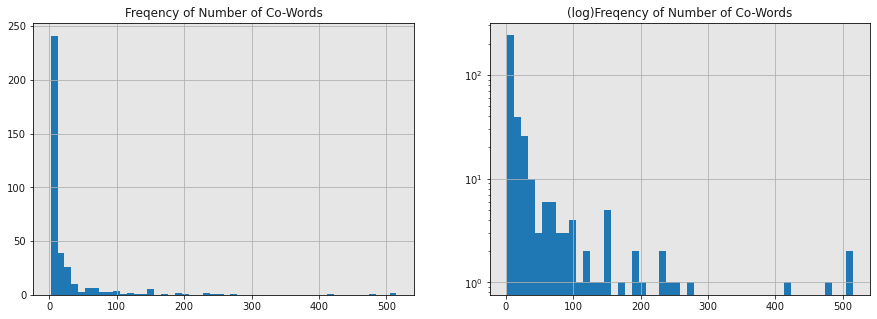

In [20]:
# part b - plot histogram (RUN THIS CELL AS IS - feel free to modify format)

# removing extreme upper tail for a better visual
counts = np.array(sample_counts)[np.array(sample_counts) < 6000]
t = sum(np.array(sample_counts) > 6000)
n = len(counts)
print("NOTE: we'll exclude the %s words with more than 6000 nbrs in this %s count sample." % (t,n))

# set up figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# plot regular hist
ax1.hist(counts, bins=50)
ax1.set_title('Freqency of Number of Co-Words', color='0.1')
ax1.set_facecolor('0.9')
ax1.tick_params(axis='both', colors='0.1')
ax1.grid(True)

# plot log scale hist
ax2.hist(counts, bins=50)
ax2.set_title('(log)Freqency of Number of Co-Words', color='0.1')
ax2.set_facecolor('0.9')
ax2.tick_params(axis='both', colors='0.1')
ax2.grid(True)
plt.yscale('log')


In [24]:
# part c - spark job
def compareRankings(rdd1, rdd2):
    percent_overlap = None
    ############# YOUR CODE HERE ###############

    result = rdd1.keys().intersection(rdd2.keys()).collect()
    
    shared_words = len(result)
    total_words = len(rdd1.collect())
    
    percent_overlap = (shared_words/total_words) * 100
    
    ############# (END) YOUR CODE ##############
    return percent_overlap

In [25]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(testRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(testRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 100.0 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 100.0 percent are also in the list of 1000 least frequent words.


In [26]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(f1RDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(f1RDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

Of the 1000 words with most neighbors, 87.6 percent are also in the list of 1000 most frequent words.
Of the 1000 words with least neighbors, 4.8 percent are also in the list of 1000 least frequent words.


In [ ]:
# part c - get lists for comparison (RUN THIS CELL AS IS...)
# (... then change 'testRDD' to 'f1RDD'/'dataRDD' when ready)
total, topWords, bottomWords = EDA1(dataRDD, 1000)
topNbrs, bottomNbrs, sample_counts = EDA2(dataRDD, 1000)
twRDD = sc.parallelize(topWords)
bwRDD = sc.parallelize(bottomWords)
tnRDD = sc.parallelize(topNbrs)
bnRDD = sc.parallelize(bottomNbrs)
top_overlap = compareRankings(tnRDD, twRDD)
bottom_overlap = compareRankings(bnRDD,bwRDD)
print(f"Of the 1000 words with most neighbors, {top_overlap} percent are also in the list of 1000 most frequent words.")
print(f"Of the 1000 words with least neighbors, {bottom_overlap} percent are also in the list of 1000 least frequent words.")

# Question 7: Basis Vocabulary & Stripes

Every word that appears in our data is a potential feature for our synonym detection analysis. However as we've discussed, some are likely to be more useful than others. In this question, you'll choose a judicious subset of these words to form our 'basis vocabulary'. Practically speaking, this means that when we build our stripes, we are only going to keep track of when a term co-occurs with one of these basis words. 


### Q7 Tasks:
* __a) multiple choice:__ Suppose we were deciding between two different basis vocabularies: the 1000 most frequent words or the 1000 least frequent words. How would this choice impact the quality of the synonyms we are able to detect? How does this choice relate to the ideas of 'overfitting' or 'underfitting' a training set?
<pre>  
  MULTIPLE CHOICE:
   A. 1000 most frequent words would overfit, while 1000 least frequent words would underfit
   B. 1000 most frequent words would underfit, while 1000 least frequent words would overfit
  
  BONUS: Explain your answer 
</pre>
* __b) short response:__ If we had a much larger dataset, computing the full ordered list of words would be extremely expensive. If we need to none-the-less get an estimate of word frequency in order to decide on a basis vocabulary, what alternative strategy could we take?

* __c) multiple choice:__ Run the provided spark job that does the following:
  * tokenizes, removes stopwords and computes a word count on the ngram data
  * subsets the top 10,000 words (these are the terms we'll consider as potential synonyms)
  * subsets words 9,000-9,999 (this will be our 1,000 word basis vocabulary)    
  (to put it another way - of the top 10,000 words, the bottom 1,000 form the basis vocabulary)
  * saves the full 10K word list and the 1K basis vocabulary to file for use in `d`.  
<pre>
  What is another way to describe the Basis Vocabulary in machine learning terms?
  A. Stop-words
  B. Features
  C. Postings
  D. 1000-grams
</pre>

* __d) code:__ Write a spark job that builds co-occurrence stripes for the top 10K words in the ngram data using the basis vocabulary you developed in `part c`. This job/function, unlike others so far, should return an RDD (which we will then use in q8).

### Q7 Student Answers:

> __a)__ 

The answer is A - 1000 most frequent words would overfit, while 1000 least frequent words would underfit. This is because these vocabulary words would provide different types of context for determining the synonyms. 

> __a-bonus)__ 

In general, the least frequent words can have a count of 1, meaning that they are very uncommon in the corpus. As a result, they would be too specific and not be able to provide much context that would be necessary in order to produce appropriate synonyms. This means there is not enough information to determine synonyms and would lead to underfitting the data. Furthermore, in a large corpus, the most common words generally consist of frequent stop words. These are not particularly useful for synonym detection. Also, the non-stop words in the 1000 most frequent are used frequently enough that their context is general, meaning that they are not specific enough to provide valuable information for calculating a synonym. This would lead to overfitting the data. Thus, the 1000 most frequent words would overfit, while 1000 least frequent words would underfit.

> __b)__ 

If we had a much larger dataset and needed to get an estimate of the word frequency in order to decide on a basis vocabulary, we would not want to top or bottom most frequent words. Instead we would want the middle most frequent words. This is because these words will be general enough to be used somewhat frequently throughout the text, but not be so frequent that they don’t provide useful information about the context. So, an alternative strategy we could take to decide on a basis vocabulary would be to calculate the size of the dataset and then use that value to find the “middle” 100 most frequent words.

> __c)__ 

The answer is B - Features.

In [16]:
# part c - provided stopwords (RUN THIS CELL AS IS)
STOPWORDS =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 'should', 'can', 'now', 'will', 'just', 
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

In [17]:
# part c - get the vocabulary and basis (RUN THIS CELL AS IS)
# 
def get_vocab(rdd, n_total, n_basis):
    vocab, basis = None, None
    ############# YOUR CODE HERE ###############
    sw = sc.broadcast(set(STOPWORDS))
    top_10k = rdd.map(lambda line: line.split('\t')[0:2])\
                 .flatMap(lambda x: [(w, int(x[1])) for w in x[0].lower().split() 
                                     if w not in sw.value])\
                 .reduceByKey(lambda x,y: x+y)\
                 .takeOrdered(n_total, key=lambda x: -x[1])
    vocab = [pair[0] for pair in top_10k]
    basis = vocab[n_total - n_basis:]
    ############# (END) YOUR CODE ##############
    return vocab, basis

In [18]:
# part c - run your job (RUN THIS CELL AS IS)
start = time.time()
VOCAB, BASIS = get_vocab(dataRDD, 10000, 1000)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 268.0176115036011 seconds

Wall time: 218.23653078079224 seconds


In [19]:
# part c - save to file (RUN THIS CELL AS IS)
with open("vocabulary.txt", "w") as file:
    file.write(str(VOCAB))
with open("basis.txt", "w") as file:
    file.write(str(BASIS))

In [34]:
# helper function 
def buildNeighbors(text_counts, VOCAB, BASIS):
    text, count, page_count, book_count = text_counts
    words = text.lower().split(" ")
    
    for i, w in enumerate(words):
        if w in VOCAB.value:
            for index in range(i+1,len(words)):
                neighbor = words[index]      
                
                if neighbor in BASIS.value and w != neighbor:
                    yield (w, neighbor)
                    
                if w in BASIS.value and neighbor in VOCAB.value and w != neighbor:
                    yield (neighbor, w)
                        

In [31]:
# helper function 
def groupNeighbors(neighbor_pairs):
    word, neighbors = neighbor_pairs
    
    neighbors = neighbors.split(",")
    unique_neighbors = set(neighbors)
               
    yield (word, unique_neighbors)

In [32]:
# part d - spark job
def buildStripes(rdd, vocab, basis):
    stripesRDD = None
    ############# YOUR CODE HERE ###############
    V = sc.broadcast(set(vocab))
    B = sc.broadcast(set(basis))
    
    stripesRDD = rdd.map(lambda line: line.split('\t')) \
              .flatMap(lambda j: buildNeighbors(j, V, B)).cache() \
              .reduceByKey(lambda x,y : x + "," + y) \
              .flatMap(groupNeighbors).cache()
    
    ############# (END) YOUR CODE ##############
    return stripesRDD

In [35]:
# part d - run your systems test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(testRDD, 10, 10)
testStripesRDD = buildStripes(testRDD, VOCAB, BASIS)
start = time.time()
print(testStripesRDD.collect())
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 0.1581110954284668 seconds
# Expected results
'''
[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]
'''

[('best', {'times'}), ('worst', {'times'}), ('foolishness', {'age'}), ('age', {'foolishness', 'times', 'wisdom'}), ('wisdom', {'age'}), ('times', {'best', 'age', 'worst'})]
Wall time: 0.16620969772338867 seconds


"\n[('worst', {'times'}), ('best', {'times'}), ('foolishness', {'age'}), ('age', {'wisdom', 'foolishness', 'times'}), ('wisdom', {'age'}), ('times', {'age', 'best', 'worst'})]\n"

In [36]:
# part d - run your single file test (RUN THIS CELL AS IS)
VOCAB, BASIS = get_vocab(f1RDD, 10000, 1000)
f1StripesRDD = buildStripes(f1RDD, VOCAB, BASIS).cache()
start = time.time()
print(f1StripesRDD.top(5))
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.55739426612854 seconds
# Expected results
'''
[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]
'''

[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'constrained', 'mould'}), ('younger', {'careers'})]
Wall time: 1.715839147567749 seconds


"\n[('zippor', {'balak'}), ('zedong', {'mao'}), ('zeal', {'infallibility'}), ('youth', {'mould', 'constrained'}), ('younger', {'careers'})]\n"

In [37]:
# part d - run the full analysis and take a look at a few stripes (RUN THIS CELL AS IS)
VOCAB = ast.literal_eval(open("vocabulary.txt", "r").read())
BASIS = ast.literal_eval(open("basis.txt", "r").read())
stripesRDD = buildStripes(dataRDD, VOCAB, BASIS).cache()

start = time.time()
for wrd, stripe in stripesRDD.top(3):
    print(wrd)
    print(list(stripe))
    print('-------')
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 214.13801431655884 seconds
# Expected results:
'''
zones
['remotest', 'adhesion', 'residential', 'subdivided', 'environments', 'gaza', 'saturation', 'localities', 'uppermost', 'warmer', 'buffer', 'parks']
-------
zone
['tribal', 'narrower', 'fibrous', 'saturation', 'originate', 'auxiliary', 'ie', 'buffer', 'transitional', 'turbulent', 'vomiting', 'americas', 'articular', 'poorly', 'intervening', 'officially', 'accumulate', 'assisting', 'flexor', 'traversed', 'unusually', 'uppermost', 'cartilage', 'inorganic', 'illuminated', 'glowing', 'contamination', 'trigger', 'masculine', 'defines', 'avoidance', 'residential', 'southeastern', 'penis', 'cracks', 'atlas', 'excitation', 'persia', 'diffuse', 'subdivided', 'alaska', 'guides', 'au', 'sandy', 'penetrating', 'parked']
-------
zinc
['ammonium', 'coating', 'pancreas', 'insoluble', "alzheimer's", 'diamond', 'radioactive', 'metallic', 'weighing', 'dysfunction', 'wasting', 'phosphorus', 'transcription', 'dipped', 'hydroxide', 'burns', 'leukemia', 'dietary']
-------
'''

zones
['residential', 'environments', 'buffer', 'subdivided', 'localities', 'saturation', 'remotest', 'parks', 'warmer', 'uppermost', 'adhesion', 'gaza']
-------
zone
['cracks', 'flexor', 'inorganic', 'diffuse', 'trigger', 'ie', 'unusually', 'glowing', 'southeastern', 'officially', 'transitional', 'au', 'saturation', 'narrower', 'fibrous', 'americas', 'intervening', 'penetrating', 'guides', 'penis', 'atlas', 'articular', 'contamination', 'defines', 'alaska', 'turbulent', 'buffer', 'illuminated', 'avoidance', 'sandy', 'poorly', 'uppermost', 'assisting', 'accumulate', 'residential', 'masculine', 'excitation', 'originate', 'subdivided', 'tribal', 'auxiliary', 'traversed', 'vomiting', 'cartilage', 'persia', 'parked']
-------
zinc
['radioactive', 'ammonium', 'hydroxide', 'dietary', 'diamond', 'leukemia', 'burns', 'coating', 'pancreas', 'metallic', 'dysfunction', 'insoluble', 'phosphorus', 'weighing', 'dipped', 'transcription', 'wasting', "alzheimer's"]
-------
Wall time: 154.5355155467987 s

'\nzones\n[\'remotest\', \'adhesion\', \'residential\', \'subdivided\', \'environments\', \'gaza\', \'saturation\', \'localities\', \'uppermost\', \'warmer\', \'buffer\', \'parks\']\n-------\nzone\n[\'tribal\', \'narrower\', \'fibrous\', \'saturation\', \'originate\', \'auxiliary\', \'ie\', \'buffer\', \'transitional\', \'turbulent\', \'vomiting\', \'americas\', \'articular\', \'poorly\', \'intervening\', \'officially\', \'accumulate\', \'assisting\', \'flexor\', \'traversed\', \'unusually\', \'uppermost\', \'cartilage\', \'inorganic\', \'illuminated\', \'glowing\', \'contamination\', \'trigger\', \'masculine\', \'defines\', \'avoidance\', \'residential\', \'southeastern\', \'penis\', \'cracks\', \'atlas\', \'excitation\', \'persia\', \'diffuse\', \'subdivided\', \'alaska\', \'guides\', \'au\', \'sandy\', \'penetrating\', \'parked\']\n-------\nzinc\n[\'ammonium\', \'coating\', \'pancreas\', \'insoluble\', "alzheimer\'s", \'diamond\', \'radioactive\', \'metallic\', \'weighing\', \'dysfu

In [38]:
# part d - save your full stripes to file for ease of retrival later... (OPTIONAL)
stripesRDD.saveAsTextFile(PWD + '/stripes')

# Question 8: Synonym Detection

We're now ready to perform the main synonym detection analysis. In the tasks below you will compute cosine, jaccard, dice and overlap similarity measurements for each pair of words in our vocabulary and then sort your results to find the most similar pairs of words in this dataset. __`IMPORTANT:`__ When you get to the sorting step please __sort on cosine similarity__ only, so that we can ensure consistent results from student to student. 

Remember to test each step of your work with the small files before running your code on the full dataset. This is a computationally intense task: well designed code can be the difference between a 20min job and a 2hr job. __`NOTE:`__ _as you are designing your code you may want to review questions 3 and 4 where we modeled some of the key pieces of this analysis._

### Q8 Tasks:
* __a) short response:__ In question 7 you wrote a function that would create word stripes for each `term` in our vocabulary. These word stripes are essentially an 'embedded representation' of the `term`'s meaning. What is the 'feature space' for this representation? (i.e. what are the features of our 1-hot encoded vectors?). What is the maximum length of a stripe?

* __b) short response:__ Remember that we are going to treat these stripes as 'documents' and perform similarity analysis on them. The first step is to emit postings which then get collected to form an 'inverted index.' How many rows will there be in our inverted index? Explain.

* __c) short response:__ In the demo from question 2, we were able to compute the cosine similarity directly from the stripes (we did this using their vector form, but could have used the list instead). So why do we need the inverted index?

* __d) code:__ Write a spark job that does the following:
  * loops over the stripes from Q7 and emits postings for the `term` _(key:term, value:posting)_   
  * aggregates the postings to create an inverted index _(key:term, value:list of postings)_
  * loops over all pairs of `term`s that appear in the same postings list and emits co-occurrence counts
  * aggregates co-occurrences _(key:word pair, value:count + other payload)_
  * uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and overlap similarity metrics for each pair of words in the vocabulary 
  * retrieve the top 20 and bottom 20 most/least similar pairs of words
  * also return the cached sorted RDD for use in the next question  
  __`NOTE 1`:__ _Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. A composite key is the way to go here._  
  __`NOTE 2`:__ _Please make sure that your final results are sorted according to cosine similarity otherwise your results may not match the expected result & you will be marked wrong._
  
* __e) code:__ Comment on the quality of the "synonyms" your analysis comes up with. Do you notice anything odd about these pairs of words? Discuss at least one idea for how you might go about improving on the analysis.

### Q8 Student Answers:

> __a)__

The word stripes are able to "represent" a term's meaning. The feature space for this representation is a vector of representative words that considered to be neighbors to the given term. So, the features of our 1-hot encoded vectors are the words that make up the basis vocabulary. the maximum length of a stripe is 1000. This is because stripes are made up of terms from the basis vocabulary, which was a 1000 word subset from the middle of the word frequency corpus. 

> __b)__

There will be 1000 rows in our inverted index. This is because each stripe was formed from the basis vocabulary, which was made up of 1000 unique terms. So, a stripe can only potentially consist of the 1000 words in that subset. As a result, the inverted index will have a row for each of those 1000 basis vocabulary terms, with a basis term - [vocab term] structure.


> __c)__ 

An inverted index is an index data structure storing a mapping from content, such as words or numbers, to its locations in a document or a set of documents. The purpose of an inverted index is to allow fast full-text searches. So, we need the inverted index in order to quickly interate through the terms and compute the cosine similarity from the postings. In general, we are able to leverage the basis term - [vocab term] structure of the inverted index to optimize our similarity calculations.


> __e)__

From our results, we can see that the quality of the "synonym" analysis is not very good. Even though they produce good similarity metric scores, most of the pairs are not necessarily synonyms at all. In general, the pairs seem to be made up of adjatives and nouns, such as "great - time". So, in order to improve the analysis, I would try to compare word pairs in the vocabulary that are not necessarily neighbors but have similar neighbors in their stripes. This would mean that the two words are used in similar contexts in the text. Thus, they would be more likely to be synonyms.

In [39]:
# helper function for pretty printing (RUN THIS CELL AS IS)
def displayOutput(lines):
    template = "{:25}|{:6}, {:7}, {:7}, {:5}"
    print(template.format("Pair", "Cosine", "Jaccard", "Overlap", "Dice"))
    for pair, scores in lines:
        scores = [round(s,4) for s in scores]
        print(template.format(pair, *scores))

In [58]:
from collections import Counter

__`TIP:`__ Feel free to define helper functions within the main function to help you organize your code. Readability is important! Eg:
```
def similarityAnlysis(stripesRDD):
    """main docstring"""
    
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############ YOUR CODE HERE ###########
    def helper1():
        """helper docstring"""
        return x
        
    def helper2():
        """helper docstring"""
        return x
        
    # main spark job starts here
    
        ...etc
    ############ (END) YOUR CODE ###########
    return simScoresRDD, top_n, bottom_n
```

In [69]:
# part d - write your spark job in the space provided
def similarityAnalysis(stripesRDD, n):
    """
    This function defines a Spark DAG to compute cosine, jaccard, 
    overlap and dice scores for each pair of words in the stripes
    provided. 
    
    Output: an RDD, a list of top n, a list of bottom n
    """
    simScoresRDD, top_n, bottom_n = None, None, None
    
    ############### YOUR CODE HERE ################
    
    #loops over the stripes from Q7 and emits postings for the term (key:term, value:posting)
    def helper1(stripes):
        term, stripe = stripes
        
        # Don't forget to include the stripe length when you are creating the postings & co-occurrence pairs. 
        # A composite key is the way to go here.
        for word in stripe:
            yield (word, [(term, len(stripe))])
            
    #loops over all pairs of terms that appear in the same postings list and emits co-occurrence counts        
    def helper2(inverted_index):
        word, postings = inverted_index
        #postings = posting_list.split(",")

        for subset in itertools.combinations(sorted(postings), 2):
            yield (str(subset), 1)
          
    #uses the counts (along with the accompanying information) to compute the cosine, jacard, dice and 
    #overlap similarity metrics for each pair of words in the vocabulary
    def helper3(line):        
        #output = "Pair", "Cosine", "Jaccard", "Overlap", "Dice"
        (doc1, n1), (doc2, n2) = ast.literal_eval(line[0])
        total = int(line[1])
        
        #cosine similarity
        cosine = total /(np.sqrt(n1) * np.sqrt(n2))
        #cosine = total / (n1*n2)
        
        #jaccard output
        jaccard = total / float(int(n1) + int(n2) - total)
        
        if n1 <= n2:
            min_size = n1
        else:
            min_size = n2
        
        #overlap output
        overlap = total / min_size
        
        #dice output
        dice = (2*total)/(n1+n2)
              
        yield (doc1+" - "+doc2, (cosine, jaccard, overlap, dice))
        
        
    # Please make sure that your final results are sorted according to cosine similarity otherwise your 
    # results may not match the expected result & you will be marked wrong.
    result = stripesRDD.map(lambda line: [line[0], line[1]]) \
                       .flatMap(helper1).cache() \
                       .reduceByKey(lambda x,y : x + y) \
                       .flatMap(helper2).cache() \
                       .reduceByKey(lambda x,y : x + y) \
                       .flatMap(helper3).cache()

    #retrieve the top 20 and bottom 20 most/least similar pairs of words
    top_n = result.takeOrdered(n, key=lambda x: -x[1][0]) 
    bottom_n = result.takeOrdered(n, key=lambda x: x[1][0]) 

    ############### (END) YOUR CODE ##############
    return result, top_n, bottom_n

In [70]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
testResult, top_n, bottom_n = similarityAnalysis(testStripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.4768586158752441 seconds

Wall time: 0.3489077091217041 seconds


In [71]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
best - worst             |   1.0,     1.0,     1.0,   1.0
foolishness - wisdom     |   1.0,     1.0,     1.0,   1.0
times - wisdom           |0.5774,  0.3333,     1.0,   0.5
age - best               |0.5774,  0.3333,     1.0,   0.5
age - worst              |0.5774,  0.3333,     1.0,   0.5
foolishness - times      |0.5774,  0.3333,     1.0,   0.5


In [72]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
f1Result, top_n, bottom_n = similarityAnalysis(f1StripesRDD, 10)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1.9845571517944336 seconds

Wall time: 2.066472053527832 seconds


In [73]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
implementation - priorities|   1.0,     1.0,     1.0,   1.0
holes - stand            |   1.0,     1.0,     1.0,   1.0
bread - cult             |   1.0,     1.0,     1.0,   1.0
cult - except            |   1.0,     1.0,     1.0,   1.0
patriotic - splendour    |   1.0,     1.0,     1.0,   1.0
represents - respiratory |   1.0,     1.0,     1.0,   1.0
bill - qualities         |   1.0,     1.0,     1.0,   1.0
qualities - specifically |   1.0,     1.0,     1.0,   1.0
converted - substance    |   1.0,     1.0,     1.0,   1.0
material - showing       |   1.0,     1.0,     1.0,   1.0


In [74]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - two               |0.0309,  0.0156,  0.0333, 0.0308
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
made - two               |0.0351,  0.0179,   0.037, 0.0351
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
made - upon              |0.0357,  0.0182,   0.037, 0.0357
two - use                |0.0358,  0.0182,  0.0385, 0.0357


In [75]:
# part d - run the system test (RUN THIS CELL AS IS... use display cell below to see results)
start = time.time()
result, top_n, bottom_n = similarityAnalysis(stripesRDD, 20)
print("Wall time: {} seconds".format(time.time() - start))
# Wall time: 1851.9786894321442 seconds

21/10/01 20:31:07 WARN MemoryStore: Not enough space to cache rdd_267_15 in memory! (computed 22.7 MiB so far)
21/10/01 20:31:07 WARN BlockManager: Block rdd_267_15 could not be removed as it was not found on disk or in memory
21/10/01 20:31:07 WARN BlockManager: Putting block rdd_267_15 failed
21/10/01 20:31:19 WARN MemoryStore: Not enough space to cache rdd_267_16 in memory! (computed 19.1 MiB so far)
21/10/01 20:31:19 WARN BlockManager: Block rdd_267_16 could not be removed as it was not found on disk or in memory
21/10/01 20:31:19 WARN BlockManager: Putting block rdd_267_16 failed
21/10/01 20:31:32 WARN MemoryStore: Not enough space to cache rdd_267_17 in memory! (computed 24.7 MiB so far)
21/10/01 20:31:32 WARN BlockManager: Block rdd_267_17 could not be removed as it was not found on disk or in memory
21/10/01 20:31:32 WARN BlockManager: Putting block rdd_267_17 failed
21/10/01 20:31:46 WARN MemoryStore: Not enough space to cache rdd_267_19 in memory! (computed 1409.8 KiB so far)

Wall time: 1072.743616104126 seconds


In [76]:
displayOutput(top_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433

In [77]:
displayOutput(bottom_n)

Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068


__Expected output f1RDD:__  
<table>
<th>MOST SIMILAR:</th>
<th>LEAST SIMILAR:</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
commentary - lady        |   1.0,     1.0,     1.0,   1.0
commentary - toes        |   1.0,     1.0,     1.0,   1.0
commentary - reply       |   1.0,     1.0,     1.0,   1.0
curious - tone           |   1.0,     1.0,     1.0,   1.0
curious - lady           |   1.0,     1.0,     1.0,   1.0
curious - owe            |   1.0,     1.0,     1.0,   1.0
lady - tone              |   1.0,     1.0,     1.0,   1.0
reply - tone             |   1.0,     1.0,     1.0,   1.0
lady - toes              |   1.0,     1.0,     1.0,   1.0
lady - reply             |   1.0,     1.0,     1.0,   1.0
</pre></td>
<td><pre>

Pair                     |Cosine, Jaccard, Overlap, Dice 
part - time              |0.0294,  0.0149,  0.0303, 0.0294
time - upon              |0.0314,  0.0159,  0.0345, 0.0312
time - two               |0.0314,  0.0159,  0.0345, 0.0312
made - time              |0.0325,  0.0164,   0.037, 0.0323
first - time             |0.0338,  0.0169,    0.04, 0.0333
new - time               |0.0352,  0.0175,  0.0435, 0.0345
part - us                |0.0355,  0.0179,  0.0417, 0.0351
little - part            |0.0355,  0.0179,  0.0417, 0.0351
made - two               |0.0357,  0.0182,   0.037, 0.0357
made - upon              |0.0357,  0.0182,   0.037, 0.0357
</pre></td></tr>
</table>

__Expected output dataRDD:__  
<table>
<th>Most Similar</th>
<th>Least Similar</th>
<tr><td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
first - time             |  0.89,  0.8012,  0.9149, 0.8897
time - well              |0.8895,   0.801,   0.892, 0.8895
great - time             | 0.875,  0.7757,   0.925, 0.8737
part - well              | 0.874,  0.7755,  0.9018, 0.8735
first - well             |0.8717,  0.7722,  0.8936, 0.8715
part - time              |0.8715,  0.7715,  0.9018, 0.871
time - upon              |0.8668,   0.763,  0.9152, 0.8656
made - time              | 0.866,  0.7619,  0.9109, 0.8649
made - well              |0.8601,  0.7531,  0.9022, 0.8592
time - way               |0.8587,  0.7487,  0.9259, 0.8563
great - well             |0.8526,  0.7412,  0.8988, 0.8514
time - two               |0.8517,  0.7389,  0.9094, 0.8498
first - great            |0.8497,  0.7381,  0.8738, 0.8493
first - part             |0.8471,  0.7348,  0.8527, 0.8471
great - upon             |0.8464,  0.7338,  0.8475, 0.8464
upon - well              |0.8444,   0.729,   0.889, 0.8433
new - time               |0.8426,   0.724,  0.9133, 0.8399
first - two              |0.8411,  0.7249,  0.8737, 0.8405
way - well               |0.8357,  0.7146,  0.8986, 0.8335
time - us                |0.8357,  0.7105,  0.9318, 0.8308

</pre></td>
<td><pre>
Pair                     |Cosine, Jaccard, Overlap, Dice 
region - write           |0.0067,  0.0032,  0.0085, 0.0065
relation - snow          |0.0067,  0.0026,  0.0141, 0.0052
cardiac - took           |0.0074,  0.0023,  0.0217, 0.0045
ever - tumor             |0.0076,   0.002,  0.0263, 0.004
came - tumor             |0.0076,   0.002,  0.0263, 0.004
let - therapy            |0.0076,   0.003,  0.0161, 0.0059
related - stay           |0.0078,  0.0036,  0.0116, 0.0072
factors - hear           |0.0078,  0.0039,  0.0094, 0.0077
implications - round     |0.0078,  0.0033,  0.0145, 0.0066
came - proteins          |0.0079,   0.002,  0.0286, 0.0041
population - window      |0.0079,  0.0039,    0.01, 0.0077
love - proportional      | 0.008,  0.0029,  0.0185, 0.0058
got - multiple           | 0.008,  0.0034,  0.0149, 0.0067
changes - fort           |0.0081,  0.0032,  0.0161, 0.0065
layer - wife             |0.0081,  0.0038,  0.0119, 0.0075
five - sympathy          |0.0081,  0.0034,  0.0149, 0.0068
arrival - essential      |0.0081,   0.004,  0.0093, 0.008
desert - function        |0.0081,  0.0031,  0.0175, 0.0062
fundamental - stood      |0.0081,  0.0038,  0.0115, 0.0077
patients - plain         |0.0081,   0.004,  0.0103, 0.0079
</pre></td></tr>
</table>

### Congratulations, you have completed HW3! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform